# Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

#Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

#Data fetch

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)


Found 3864 files belonging to 11 classes.
Using 3478 files for training.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 435 files belonging to 11 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

#Build model

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Callback and data augmentation objects:

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='checkpoint_vgg16.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

##### VGG16 class:

In [ ]:
class Vgg16:

    LOSS = 'categorical_crossentropy'

    def __init__(self, train=None, test=None, val=None, classes=11, epochs=10,
                 callbacks_list=None, data_augmentation=None, class_weights=None):
        # set datasets
        self.training_set = train
        self.test_set = test
        self.val_set = val

        # model
        self.model = None

        # utils
        self.history = None
        self.classes = classes
        self.epochs = epochs
        self.callbacks_list = callbacks_list
        self.data_augmentation= data_augmentation
        self.vgg16dict = {}
        self.class_weights=class_weights

    """
        ARCHITECTURE TO TEST
    """
    def classic_vgg16(self):
        inputs = self.input()
        x = self.base_vgg16()(inputs)
        x = layers.Flatten(name='my_flatten')(x)
        x = layers.Dense(256, activation='relu', name='my_dense1')(x)
        x = layers.Dense(256, activation='relu', name='my_dense2')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def classic_vgg16_dropout(self):
        inputs = self.input()
        x = self.base_vgg16()(inputs)
        x = layers.Flatten(name='my_flatten')(x)
        x = layers.Dense(256, activation='relu', name='my_dense1')(x)
        x = layers.Dense(256, activation='relu', name='my_dense2')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def vgg16_finetuned(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.Flatten(name='my_flatten')(x)
        x = layers.Dense(256, activation='relu', name='my_dense1')(x)
        x = layers.Dense(256, activation='relu', name='my_dense2')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def vgg16_finetuned_dropout(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.Flatten(name='my_flatten')(x)
        x = layers.Dense(256, activation='relu', name='my_dense1')(x)
        x = layers.Dense(256, activation='relu', name='my_dense2')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def vgg16_finetuned_dropout_reg(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.Flatten(name='my_flatten')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense1',
                         kernel_regularizer=regularizers.l1_l2(0.002, 0.002))(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense2',
                         kernel_regularizer=regularizers.l1_l2(0.002, 0.002))(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    """
        NETWORK PIECE BY PIECE STRUCTURE BLOCK
    """

    def input(self):
        inputs = ks.Input(shape=(256, 256, 3))
        x = ks.applications.vgg16.preprocess_input(inputs)
        x = self.data_augmentation(x)
        x = layers.Rescaling(1. / 255)(x)
        return x

    def base_vgg16(self):
        res = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=((256, 256, 3))
        )
        res.trainable = False
        return res

    def fine_tuning(self, num_of_blocks=1):
        if num_of_blocks < 1:
            num_of_blocks = 1

        res = self.base_vgg16()
        res.trainable = True
        set_trainable = False

        if num_of_blocks == 1:
            block_name = 'block5_conv3'
        else:
            block_name = 'block5_conv2'

        for layer in res.layers:
            if layer.name == block_name:
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        return res

    """
        UTILITIES
    """

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, model_name, show_shapes=True)

    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
        plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.plot()

    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
        plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.plot()

    def summary(self):
        self.model.summary()

    """
        COMPILE AND FIT
    """
    def compile_and_fit(self, optimizer, activation=None,  ga=False):
        self.model.compile(
            optimizer=optimizer,
            loss=self.LOSS,
            metrics=['accuracy']
        )

        if self.callbacks_list is None:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set
            )
        else:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set,
                callbacks=self.callbacks_list,
                class_weight=self.class_weights
            )

    def evaluate(self):
        test_loss, test_acc = self.model.evaluate(self.test_set)
        print(f"Test accuracy: {test_acc:.3f}")

#### Feature extraction:

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=25)
vgg16.classic_vgg16()
vgg16.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 predictions (Dense)         (None, 11)                2827      
                                                            

Show graph:

In [ ]:
vgg16.plot_model('vgg_feature_extraction.png')

Test using rmsprop as optimizer:

In [ ]:
vgg16.compile_and_fit(optimizer='rmsprop')

Epoch 1/25
28/28 [==============================] - 48s 1s/step - loss: 50.1419 - accuracy: 0.2907 - val_loss: 4.5029 - val_accuracy: 0.4404
Epoch 2/25
28/28 [==============================] - 46s 1s/step - loss: 3.9188 - accuracy: 0.6032 - val_loss: 3.5018 - val_accuracy: 0.5259
Epoch 3/25
28/28 [==============================] - 46s 1s/step - loss: 1.6121 - accuracy: 0.7562 - val_loss: 6.2163 - val_accuracy: 0.5415
Epoch 4/25
28/28 [==============================] - 46s 1s/step - loss: 1.8680 - accuracy: 0.7754 - val_loss: 4.6247 - val_accuracy: 0.5311
Epoch 5/25
28/28 [==============================] - 46s 1s/step - loss: 1.2579 - accuracy: 0.8306 - val_loss: 1.9625 - val_accuracy: 0.7383
Epoch 6/25
28/28 [==============================] - 46s 1s/step - loss: 1.4318 - accuracy: 0.8982 - val_loss: 10.1950 - val_accuracy: 0.4922
Epoch 7/25
28/28 [==============================] - 46s 1s/step - loss: 0.5950 - accuracy: 0.9241 - val_loss: 2.4989 - val_accuracy: 0.7565
Epoch 8/25
28/28 [

Plot the results:

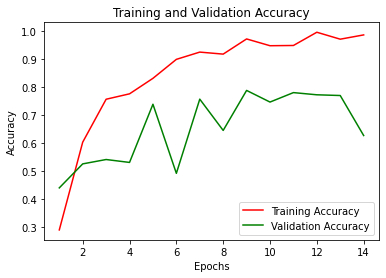

In [ ]:
vgg16.plot_accuracy()

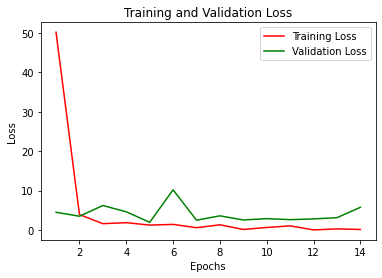

In [ ]:
vgg16.plot_loss()

Test on testset:

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 22s 6s/step - loss: 5.7002 - accuracy: 0.6391
Test accuracy: 0.639


### Adding dropout

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.classic_vgg16_dropout()
vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                              

In [ ]:
vgg16.compile_and_fit(optimizer='rmsprop')

Epoch 1/60
28/28 [==============================] - 102s 2s/step - loss: 37.9743 - accuracy: 0.2096 - val_loss: 2.0219 - val_accuracy: 0.3472
Epoch 2/60
28/28 [==============================] - 46s 1s/step - loss: 3.5002 - accuracy: 0.3120 - val_loss: 2.0691 - val_accuracy: 0.4171
Epoch 3/60
28/28 [==============================] - 46s 1s/step - loss: 3.0190 - accuracy: 0.3767 - val_loss: 1.9691 - val_accuracy: 0.4819
Epoch 4/60
28/28 [==============================] - 46s 1s/step - loss: 2.6047 - accuracy: 0.4416 - val_loss: 2.0036 - val_accuracy: 0.4663
Epoch 5/60
28/28 [==============================] - 46s 1s/step - loss: 1.9615 - accuracy: 0.5457 - val_loss: 1.9027 - val_accuracy: 0.5492
Epoch 6/60
28/28 [==============================] - 46s 1s/step - loss: 1.5717 - accuracy: 0.6208 - val_loss: 1.7336 - val_accuracy: 0.5415
Epoch 7/60
28/28 [==============================] - 46s 1s/step - loss: 1.4806 - accuracy: 0.6714 - val_loss: 2.6649 - val_accuracy: 0.5363
Epoch 8/60
28/28 [

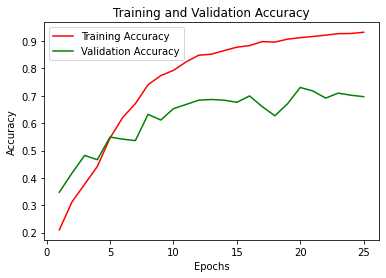

In [ ]:
vgg16.plot_accuracy()

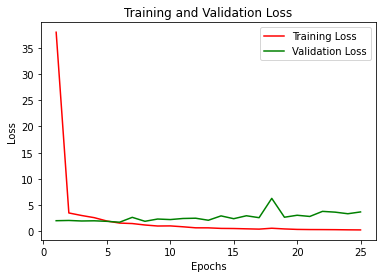

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

### Finetune one block without dropout

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.vgg16_finetuned(num_of_blocks=1)
vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 predictions (Dense)         (None, 11)                2827      
                                                                 
Total params: 23,172,171
Trainable params: 10,817,291
Non-t

In [ ]:
vgg16.compile_and_fit(optimizer='rmsprop')

Epoch 1/60
28/28 [==============================] - 55s 2s/step - loss: 24.5361 - accuracy: 0.2918 - val_loss: 3.6516 - val_accuracy: 0.3601
Epoch 2/60
28/28 [==============================] - 54s 2s/step - loss: 1.9370 - accuracy: 0.5368 - val_loss: 1.7598 - val_accuracy: 0.5596
Epoch 3/60
28/28 [==============================] - 53s 2s/step - loss: 1.4934 - accuracy: 0.6748 - val_loss: 2.7289 - val_accuracy: 0.4767
Epoch 4/60
28/28 [==============================] - 54s 2s/step - loss: 0.9269 - accuracy: 0.8022 - val_loss: 2.5953 - val_accuracy: 0.5855
Epoch 5/60
28/28 [==============================] - 54s 2s/step - loss: 1.6278 - accuracy: 0.8341 - val_loss: 8.7028 - val_accuracy: 0.3161
Epoch 6/60
28/28 [==============================] - 66s 2s/step - loss: 0.9840 - accuracy: 0.8718 - val_loss: 1.8894 - val_accuracy: 0.6839
Epoch 7/60
28/28 [==============================] - 53s 2s/step - loss: 0.6494 - accuracy: 0.9037 - val_loss: 2.3414 - val_accuracy: 0.6865
Epoch 8/60
28/28 [=

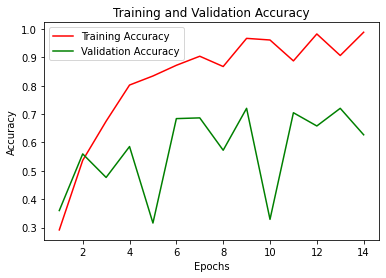

In [ ]:
vgg16.plot_accuracy()

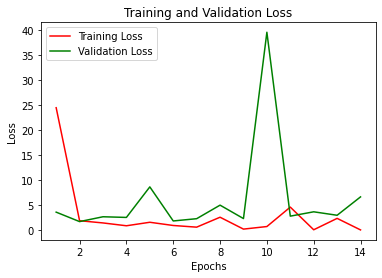

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 31s 9s/step - loss: 8.1707 - accuracy: 0.6253
Test accuracy: 0.625


Fine tune 1 layer + dropout

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.vgg16_finetuned_dropout(num_of_blocks=1)
vgg16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 11)                2827

In [ ]:
vgg16.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 59s 2s/step - loss: 7.5235 - accuracy: 0.2243 - val_loss: 2.0277 - val_accuracy: 0.4223
Epoch 2/60
28/28 [==============================] - 54s 2s/step - loss: 2.1910 - accuracy: 0.4873 - val_loss: 1.6699 - val_accuracy: 0.4845
Epoch 3/60
28/28 [==============================] - 54s 2s/step - loss: 1.2585 - accuracy: 0.6394 - val_loss: 1.4626 - val_accuracy: 0.5596
Epoch 4/60
28/28 [==============================] - 54s 2s/step - loss: 0.8409 - accuracy: 0.7501 - val_loss: 1.4537 - val_accuracy: 0.5751
Epoch 5/60
28/28 [==============================] - 54s 2s/step - loss: 0.5912 - accuracy: 0.8191 - val_loss: 1.3643 - val_accuracy: 0.6088
Epoch 6/60
28/28 [==============================] - 53s 2s/step - loss: 0.4277 - accuracy: 0.8726 - val_loss: 1.4496 - val_accuracy: 0.6321
Epoch 7/60
28/28 [==============================] - 53s 2s/step - loss: 0.3107 - accuracy: 0.9048 - val_loss: 1.4158 - val_accuracy: 0.6321
Epoch 8/60
28/28 [==

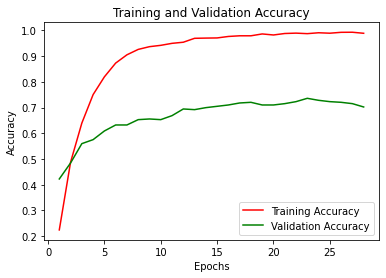

In [ ]:
vgg16.plot_accuracy()

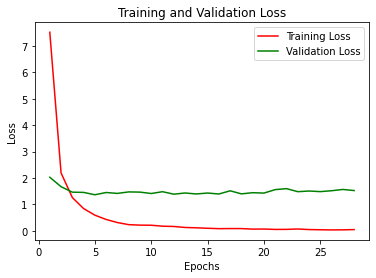

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 9s 1s/step - loss: 1.1792 - accuracy: 0.7218
Test accuracy: 0.722


#### Two layers fined tuned

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.vgg16_finetuned_dropout(num_of_blocks=2)
vgg16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 11)                2827

In [ ]:
vgg16.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 56s 2s/step - loss: 5.2278 - accuracy: 0.1958 - val_loss: 2.0241 - val_accuracy: 0.3212
Epoch 2/60
28/28 [==============================] - 55s 2s/step - loss: 2.2942 - accuracy: 0.3005 - val_loss: 1.8328 - val_accuracy: 0.3860
Epoch 3/60
28/28 [==============================] - 55s 2s/step - loss: 1.8800 - accuracy: 0.4227 - val_loss: 1.6740 - val_accuracy: 0.4637
Epoch 4/60
28/28 [==============================] - 55s 2s/step - loss: 1.4248 - accuracy: 0.5644 - val_loss: 1.4715 - val_accuracy: 0.5233
Epoch 5/60
28/28 [==============================] - 55s 2s/step - loss: 1.0202 - accuracy: 0.6889 - val_loss: 1.3119 - val_accuracy: 0.5751
Epoch 6/60
28/28 [==============================] - 56s 2s/step - loss: 0.7079 - accuracy: 0.7838 - val_loss: 1.2529 - val_accuracy: 0.6140
Epoch 7/60
28/28 [==============================] - 55s 2s/step - loss: 0.5286 - accuracy: 0.8370 - val_loss: 1.1708 - val_accuracy: 0.6477
Epoch 8/60
28/28 [==

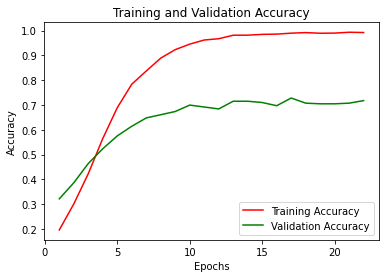

In [ ]:
vgg16.plot_accuracy()

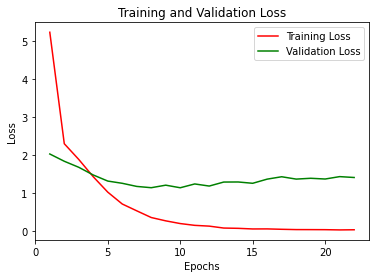

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 10s 1s/step - loss: 1.2589 - accuracy: 0.7379
Test accuracy: 0.738


### ADDING L1 L2 reg to previous network

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.vgg16_finetuned_dropout_reg(num_of_blocks=2)
vgg16.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 11)                2827

In [ ]:
vgg16.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 57s 2s/step - loss: 123.4480 - accuracy: 0.1567 - val_loss: 114.8204 - val_accuracy: 0.2720
Epoch 2/60
28/28 [==============================] - 55s 2s/step - loss: 109.6391 - accuracy: 0.2539 - val_loss: 102.7218 - val_accuracy: 0.3316
Epoch 3/60
28/28 [==============================] - 56s 2s/step - loss: 97.1196 - accuracy: 0.3749 - val_loss: 90.3197 - val_accuracy: 0.4819
Epoch 4/60
28/28 [==============================] - 55s 2s/step - loss: 84.8900 - accuracy: 0.5242 - val_loss: 78.8515 - val_accuracy: 0.5725
Epoch 5/60
28/28 [==============================] - 55s 2s/step - loss: 73.7860 - accuracy: 0.6901 - val_loss: 68.8414 - val_accuracy: 0.6295
Epoch 6/60
28/28 [==============================] - 56s 2s/step - loss: 64.3182 - accuracy: 0.7829 - val_loss: 60.3213 - val_accuracy: 0.6839
Epoch 7/60
28/28 [==============================] - 56s 2s/step - loss: 56.1907 - accuracy: 0.8514 - val_loss: 52.9289 - val_accuracy: 0.6710
Ep

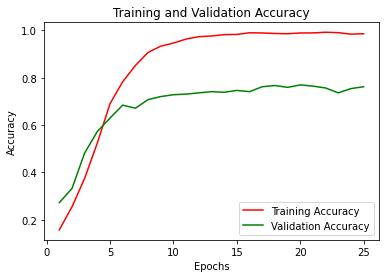

In [ ]:
vgg16.plot_accuracy()

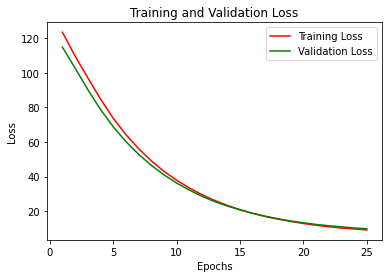

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 9s 1s/step - loss: 9.8097 - accuracy: 0.7494
Test accuracy: 0.749


## Fine tune 1 + drop + reg

In [ ]:
vgg16 = Vgg16(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
vgg16.vgg16_finetuned_dropout_reg(num_of_blocks=1)
vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 my_flatten (Flatten)        (None, 32768)             0         
                                                                 
 my_dense1 (Dense)           (None, 256)               8388864   
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                              

In [ ]:
vgg16.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 100s 2s/step - loss: 127.2621 - accuracy: 0.2182 - val_loss: 118.2728 - val_accuracy: 0.4508
Epoch 2/60
28/28 [==============================] - 47s 1s/step - loss: 115.5346 - accuracy: 0.4373 - val_loss: 111.2282 - val_accuracy: 0.5052
Epoch 3/60
28/28 [==============================] - 46s 1s/step - loss: 107.4695 - accuracy: 0.6259 - val_loss: 103.7608 - val_accuracy: 0.5518
Epoch 4/60
28/28 [==============================] - 46s 1s/step - loss: 99.6884 - accuracy: 0.7263 - val_loss: 96.3082 - val_accuracy: 0.5699
Epoch 5/60
28/28 [==============================] - 46s 1s/step - loss: 92.1633 - accuracy: 0.8140 - val_loss: 89.1645 - val_accuracy: 0.6010
Epoch 6/60
28/28 [==============================] - 46s 1s/step - loss: 85.0688 - accuracy: 0.8652 - val_loss: 82.3733 - val_accuracy: 0.6218
Epoch 7/60
28/28 [==============================] - 46s 1s/step - loss: 78.4089 - accuracy: 0.8974 - val_loss: 75.9900 - val_accuracy: 0.6477

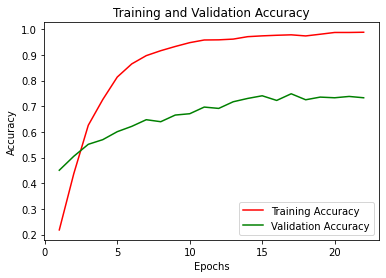

In [ ]:
vgg16.plot_accuracy()

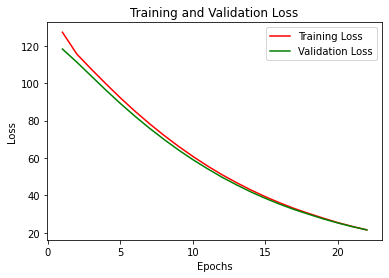

In [ ]:
vgg16.plot_loss()

In [ ]:
vgg16.evaluate()

4/4 [==============================] - 26s 7s/step - loss: 21.5590 - accuracy: 0.7471
Test accuracy: 0.747
